refs: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [94]:
import uproot
import numpy as np
from reco.plotting import plot_event, plot_remapped, plot_tracksters
from reco.evaluation import evaluate
from reco.event import remap_array_by_label
from reco.energy import get_total_energy
import matplotlib.pyplot as plt
import awkward as ak
%matplotlib inline

# file_name = "~/Data/pions/new_ntuples_14955802_7.root"
file_name = "~/data/multi/new_ntuples_14992862_991.root"


tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

Tracksters reco: 78, tracksters sim: 10
Simulated energy: 3522.02, reconstructed energy: 3123.60 (88.69%)


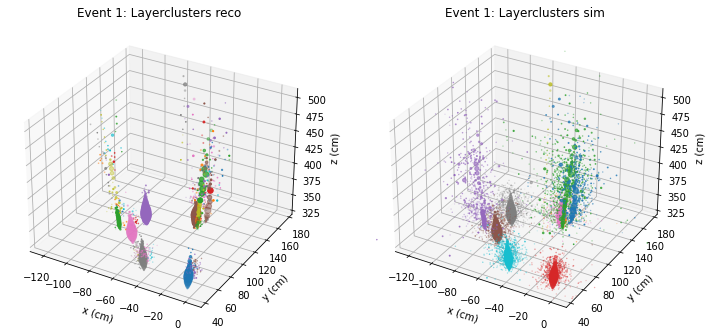

In [72]:
eid = 1

t_indexes = tracksters["vertices_indexes"].array()[eid]
t_energy = tracksters["vertices_energy"].array()[eid]
v_multi = tracksters["vertices_multiplicity"].array()[eid]
st_indexes = simtracksters["stsSC_vertices_indexes"].array()[eid]
st_energy = simtracksters["stsSC_vertices_energy"].array()[eid]
sv_multi = simtracksters["stsSC_vertices_multiplicity"].array()[eid]

print(f"Tracksters reco: {len(t_indexes)}, tracksters sim: {len(st_indexes)}")

reco_total = get_total_energy(t_energy, v_multi)
sim_total = get_total_energy(st_energy, sv_multi)
print(f"Simulated energy: {sim_total:.2f}, reconstructed energy: {reco_total:.2f} ({(reco_total / sim_total) * 100:.2f}%)")

plot_event(tracksters, simtracksters, eid, legend=False)

In [73]:
precision, recall, fscore = evaluate(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 0.97, Recall: 0.06, F-score: 0.11


In [74]:
def evaluate_remapped(labels):
    ri = remap_array_by_label(t_indexes, labels)
    re = remap_array_by_label(t_energy, labels)
    rm = remap_array_by_label(v_multi, labels)
    precision, recall, fscore = evaluate(ri, st_indexes, re, st_energy, rm, sv_multi, noise=False)
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")
    

In [75]:
from sklearn.decomposition import PCA

In [181]:
pca_components = []

tvx = tracksters["vertices_x"].array()[eid]
tvy = tracksters["vertices_y"].array()[eid]
tvz = tracksters["vertices_z"].array()[eid]

for t_id in range(len(tvx)):
    X = np.array([tvx[t_id], tvy[t_id], tvz[t_id]]).T   # shape: (datapoint, coords)
    if X.shape[0] > 2:                                  # at least two datapoints (LC)

        pca = PCA(n_components=3).fit(X).transform(X)   # (datapoint, coords)
        pca_components.append(pca.T)                    # trackster, coord, datapoint

transformed = ak.Array(pca_components)

- TODO:
- extract features (also about vertices dimensional)

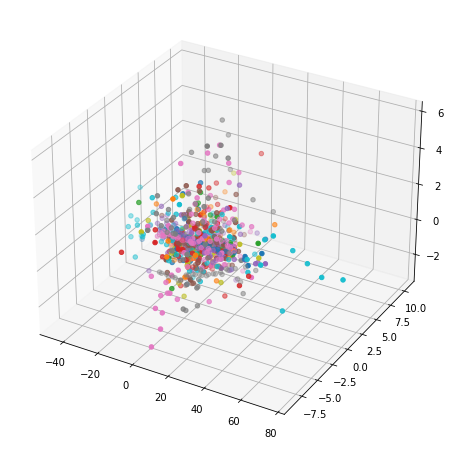

In [180]:
# layerclusters in PCA space

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(transformed)):
    ax.scatter(transformed[i,0], transformed[i,1], transformed[i,2], label=i)

plt.show()

Got the layerclusters in PCA space
- this is a mess because I don't consider dependencies between tracksters (need to add mean?)
- next steps?